# Forecasting with Machine Learning

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

from functools import partial

import warnings
warnings.filterwarnings("ignore")

In [6]:
def plot_metrics_bar(eval_df):
    methods = eval_df.columns[1:]
    values = eval_df.iloc[0].values[1:]
    
    sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
    methods_sorted, values_sorted = zip(*sorted_data)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(methods_sorted, values_sorted)
    
    for bar, value in zip(bars, values_sorted):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Methods')
    plt.ylabel('Mean absolute error (MAE)')
    plt.tight_layout()
    
    plt.show()

In [7]:
data_url = "https://raw.githubusercontent.com/marcopeix/youtube_tutorials/refs/heads/main/data/daily_sales_french_bakery.csv"
df = pd.read_csv(data_url, parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


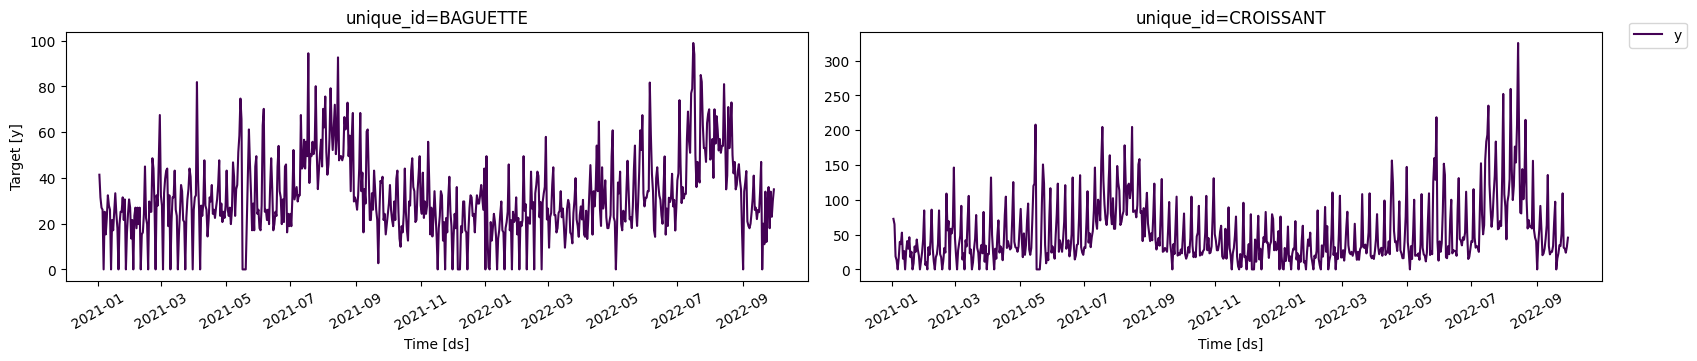

In [8]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], palette="viridis")

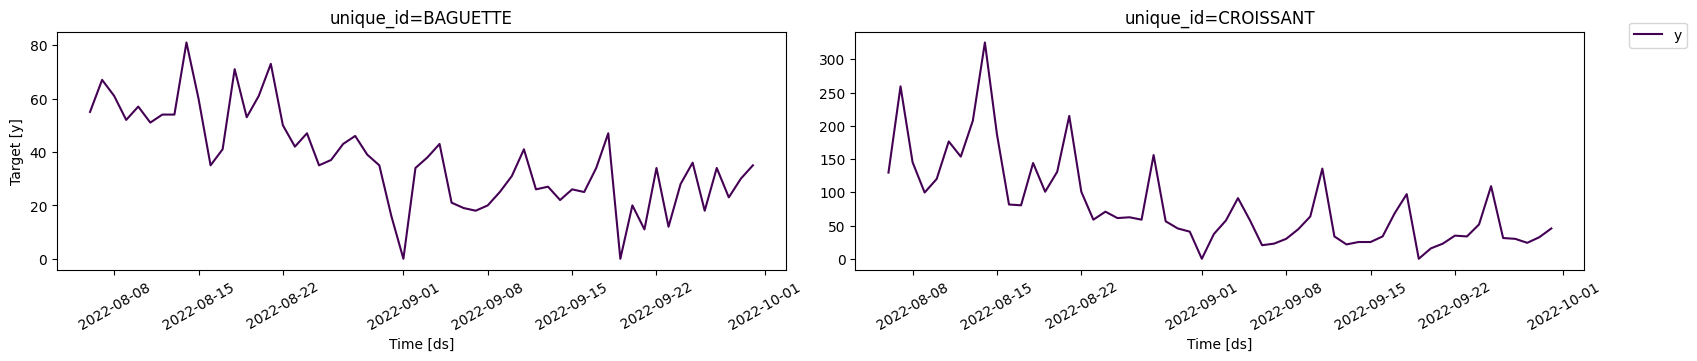

In [9]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")

## Baseline model

In [10]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive

In [11]:
horizon = 7

In [12]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7),
]

sf = StatsForecast(models=models, freq="D")
baseline_cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

temp_test = small_df.groupby("unique_id").tail(7*8)
eval_train_df = small_df.drop(temp_test.index).reset_index(drop=True)

evaluation = evaluate(
    baseline_cv_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,SeasonalNaive
0,mae,21.117857
1,mase,1.328592


## Machine learning models

In [13]:
from mlforecast import MLForecast

import lightgbm as lgb
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
models ={
    'lgbm': lgb.LGBMRegressor(verbosity=-1),
    'lasso': Lasso(),
    'lin_reg': LinearRegression(),
    'ridge': Ridge(),
    'knn': KNeighborsRegressor(),
    'gbr': GradientBoostingRegressor()
}

### Building features
#### Lags

In [15]:
mlf = MLForecast(
    models = models, 
    freq='D',
    lags=range(1,8),
)

In [16]:
prep_df = mlf.preprocess(small_df, static_features=[])
prep_df.head()

,unique_id,ds,y,unit_price,lag1,lag2,lag3,lag4,lag5,lag6,lag7
91,BAGUETTE,2021-01-09,22.5,0.9,15.3,25.2,0.0,26.1,27.0,31.5,41.4
92,BAGUETTE,2021-01-10,32.4,0.9,22.5,15.3,25.2,0.0,26.1,27.0,31.5
93,BAGUETTE,2021-01-11,27.9,0.9,32.4,22.5,15.3,25.2,0.0,26.1,27.0
94,BAGUETTE,2021-01-12,26.1,0.9,27.9,32.4,22.5,15.3,25.2,0.0,26.1
95,BAGUETTE,2021-01-13,0.0,0.9,26.1,27.9,32.4,22.5,15.3,25.2,0.0


In [17]:
small_df.head(14)

,unique_id,ds,y,unit_price
84,BAGUETTE,2021-01-02,41.4,0.9
85,BAGUETTE,2021-01-03,31.5,0.9
86,BAGUETTE,2021-01-04,27.0,0.9
87,BAGUETTE,2021-01-05,26.1,0.9
88,BAGUETTE,2021-01-06,0.0,0.9
89,BAGUETTE,2021-01-07,25.2,0.9
90,BAGUETTE,2021-01-08,15.3,0.9
91,BAGUETTE,2021-01-09,22.5,0.9
92,BAGUETTE,2021-01-10,32.4,0.9
93,BAGUETTE,2021-01-11,27.9,0.9


In [18]:
ml_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=False,
    static_features=[]
)

full_eval_df = baseline_cv_df.merge(ml_cv_df.drop(["cutoff", "y"], axis=1), "left", ["unique_id", "ds"])

full_evaluation = evaluate(
    full_eval_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
full_evaluation = full_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
full_evaluation

,metric,SeasonalNaive,lgbm,lasso,lin_reg,ridge,knn,gbr
0,mae,21.117857,26.260955,19.565007,19.679879,19.665216,18.959107,20.494700
1,mase,1.328592,1.604936,1.207426,1.211638,1.211006,1.232979,1.239813


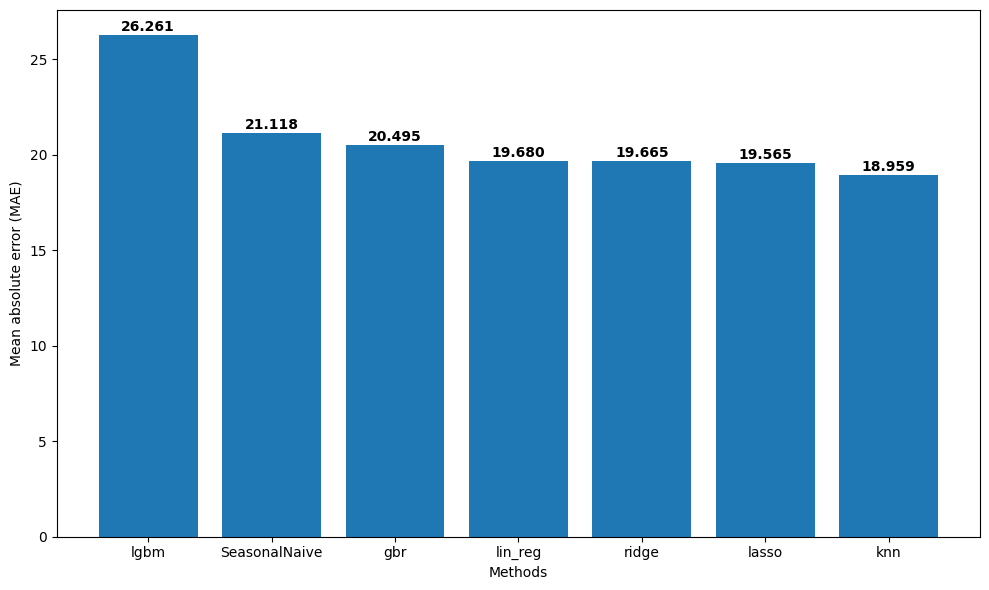

In [20]:
plot_metrics_bar(full_evaluation)

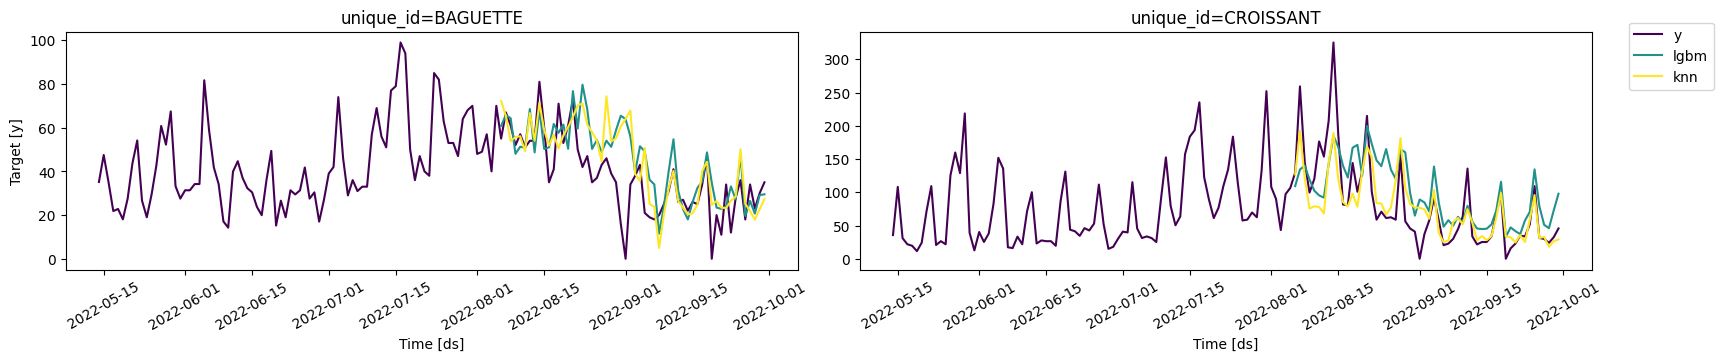

In [21]:
plot_series(
    df=small_df, 
    forecasts_df=full_eval_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    models=["lgbm", "knn"],
    max_insample_length=140,
    palette="viridis"
)

#### Lag transformations

In [22]:
from mlforecast.lag_transforms import RollingMean, ExpandingMean

In [23]:
mlf = MLForecast(
    models = models, 
    freq='D',
    lags=range(1,8),
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=7)]
    }
)
prep_df = mlf.preprocess(small_df, static_features=[])
prep_df.head()

,unique_id,ds,y,unit_price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,expanding_mean_lag1,rolling_mean_lag7_window_size7
97,BAGUETTE,2021-01-15,17.1,0.9,21.6,0.0,26.1,27.9,32.4,22.5,15.3,22.846154,23.785714
98,BAGUETTE,2021-01-16,25.2,0.9,17.1,21.6,0.0,26.1,27.9,32.4,22.5,22.435714,21.085714
99,BAGUETTE,2021-01-17,33.3,0.9,25.2,17.1,21.6,0.0,26.1,27.9,32.4,22.620000,21.214286
100,BAGUETTE,2021-01-18,24.3,0.9,33.3,25.2,17.1,21.6,0.0,26.1,27.9,23.287500,21.342857
101,BAGUETTE,2021-01-19,18.0,0.9,24.3,33.3,25.2,17.1,21.6,0.0,26.1,23.347059,21.342857


In [24]:
ml_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=False,
    static_features=[]
)

full_eval_df = baseline_cv_df.merge(ml_cv_df.drop(["cutoff", "y"], axis=1), "left", ["unique_id", "ds"])

full_evaluation = evaluate(
    full_eval_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
full_evaluation = full_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
full_evaluation

,metric,SeasonalNaive,lgbm,lasso,lin_reg,ridge,knn,gbr
0,mae,21.117857,25.489185,17.785720,17.855431,17.819841,18.535804,25.504589
1,mase,1.328592,1.527270,1.107425,1.111553,1.109312,1.213854,1.509130


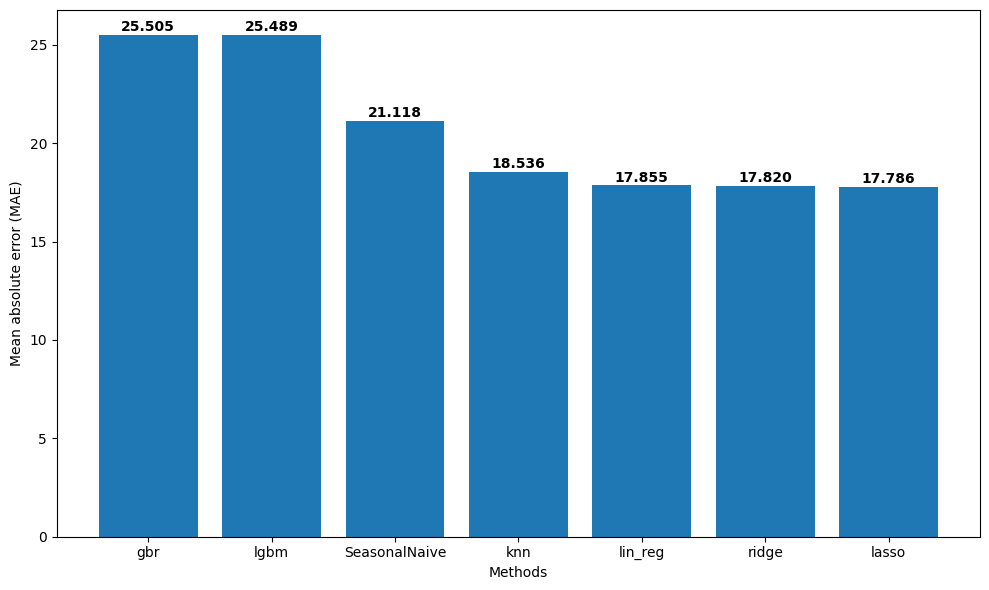

In [25]:
plot_metrics_bar(full_evaluation)

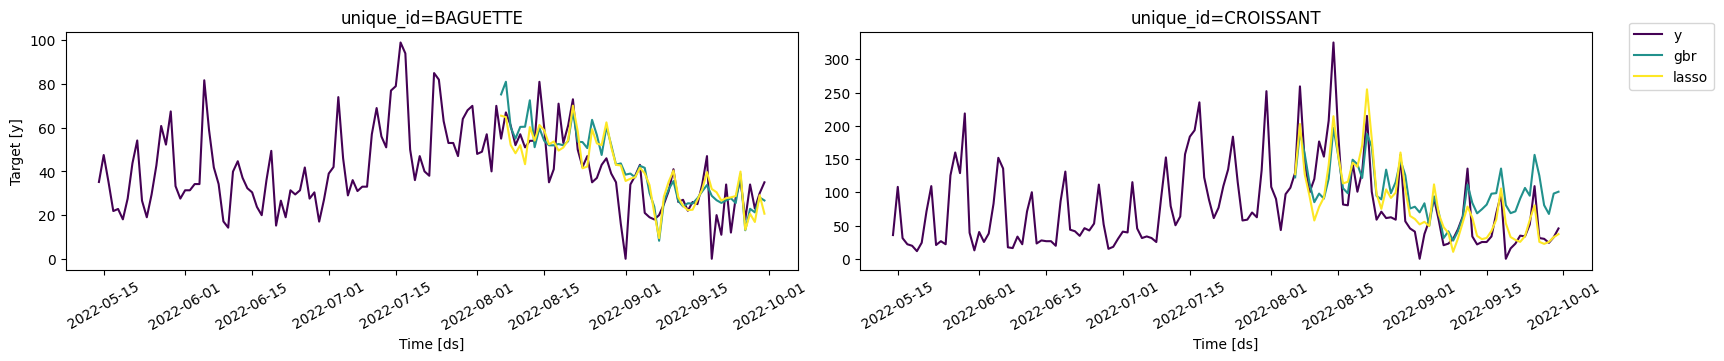

In [26]:
plot_series(
    df=small_df, 
    forecasts_df=full_eval_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    models=["gbr", "lasso"],
    max_insample_length=140,
    palette="viridis"
)

#### Date features

In [27]:
mlf = MLForecast(
    models = models, 
    freq='D',
    lags=range(1,8),
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=7)]
    },
    date_features=["month", "dayofweek"]
)
prep_df = mlf.preprocess(small_df, static_features=[])
prep_df.head()

,unique_id,ds,y,unit_price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,expanding_mean_lag1,rolling_mean_lag7_window_size7,month,dayofweek
97,BAGUETTE,2021-01-15,17.1,0.9,21.6,0.0,26.1,27.9,32.4,22.5,15.3,22.846154,23.785714,1,4
98,BAGUETTE,2021-01-16,25.2,0.9,17.1,21.6,0.0,26.1,27.9,32.4,22.5,22.435714,21.085714,1,5
99,BAGUETTE,2021-01-17,33.3,0.9,25.2,17.1,21.6,0.0,26.1,27.9,32.4,22.620000,21.214286,1,6
100,BAGUETTE,2021-01-18,24.3,0.9,33.3,25.2,17.1,21.6,0.0,26.1,27.9,23.287500,21.342857,1,0
101,BAGUETTE,2021-01-19,18.0,0.9,24.3,33.3,25.2,17.1,21.6,0.0,26.1,23.347059,21.342857,1,1


In [28]:
ml_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=False,
    static_features=[]
)

full_eval_df = baseline_cv_df.merge(ml_cv_df.drop(["cutoff", "y"], axis=1), "left", ["unique_id", "ds"])

full_evaluation = evaluate(
    full_eval_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
full_evaluation = full_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
full_evaluation

,metric,SeasonalNaive,lgbm,lasso,lin_reg,ridge,knn,gbr
0,mae,21.117857,22.401635,18.503282,19.280354,18.977479,18.454018,21.699633
1,mase,1.328592,1.390424,1.195637,1.265252,1.242376,1.205637,1.345540


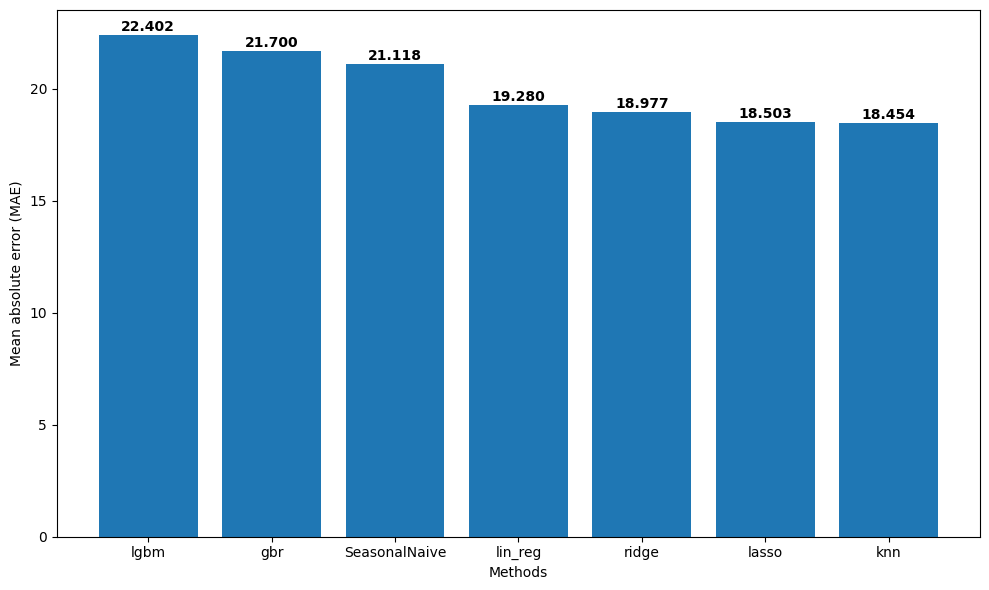

In [29]:
plot_metrics_bar(full_evaluation)

#### Target transformations

In [30]:
from mlforecast.target_transforms import Differences

In [31]:
mlf = MLForecast(
    models = models, 
    freq='D',
    lags=range(1,8),
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=7)]
    },
    target_transforms=[Differences([7])]
)
prep_df = mlf.preprocess(small_df, static_features=[])
prep_df.head()

,unique_id,ds,y,unit_price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,expanding_mean_lag1,rolling_mean_lag7_window_size7
104,BAGUETTE,2021-01-22,8.100000e+00,0.9,-1.800000e+00,0.000000e+00,-8.100000e+00,-3.6,0.9,2.7,1.8,-2.215385,-2.700000
105,BAGUETTE,2021-01-23,3.552714e-15,0.9,8.100000e+00,-1.800000e+00,0.000000e+00,-8.1,-3.6,0.9,2.7,-1.478571,0.385714
106,BAGUETTE,2021-01-24,-1.800000e+00,0.9,3.552714e-15,8.100000e+00,-1.800000e+00,0.0,-8.1,-3.6,0.9,-1.380000,0.385714
107,BAGUETTE,2021-01-25,-2.700000e+00,0.9,-1.800000e+00,3.552714e-15,8.100000e+00,-1.8,0.0,-8.1,-3.6,-1.406250,-0.257143
108,BAGUETTE,2021-01-26,1.260000e+01,0.9,-2.700000e+00,-1.800000e+00,3.552714e-15,8.1,-1.8,0.0,-8.1,-1.482353,-1.414286


In [32]:
ml_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=False,
    static_features=[]
)

full_eval_df = baseline_cv_df.merge(ml_cv_df.drop(["cutoff", "y"], axis=1), "left", ["unique_id", "ds"])

full_evaluation = evaluate(
    full_eval_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
full_evaluation = full_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
full_evaluation

,metric,SeasonalNaive,lgbm,lasso,lin_reg,ridge,knn,gbr
0,mae,21.117857,19.288306,20.358101,20.102476,20.081000,19.697321,18.306242
1,mase,1.328592,1.219992,1.272235,1.254672,1.253724,1.279640,1.192757


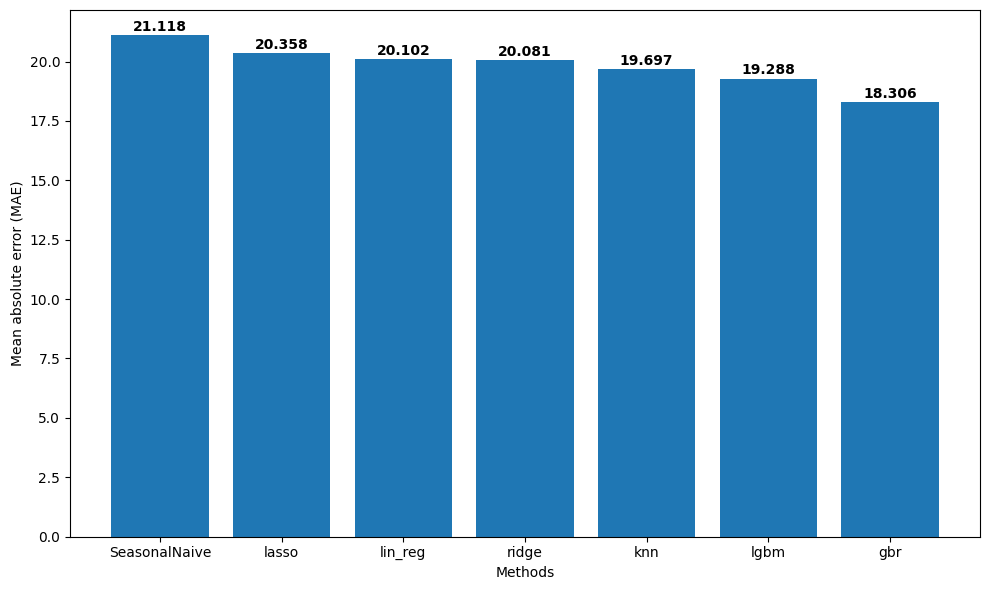

In [33]:
plot_metrics_bar(full_evaluation)

In [34]:
from scipy.fftpack import fft, fftfreq

def analyze_frequencies(signal, sampling_rate):
    signal = signal.values
    n = len(signal)
    fft_values = fft(signal)

    freq = fftfreq(n, 1/sampling_rate)
    
    positive_freq_idx = np.arange(1, n//2)
    frequencies = freq[positive_freq_idx]
    amplitudes = 2.0/n * np.abs(fft_values[positive_freq_idx])
    
    top_indices = np.argsort(amplitudes)[-5:][::-1]
    
    top_frequencies = frequencies[top_indices]
    top_amplitudes = amplitudes[top_indices]
    
    return top_frequencies, top_amplitudes

In [35]:
top_frequencies, top_amplitudes = analyze_frequencies(small_df['y'], sampling_rate=1)

In [36]:
1/top_frequencies

array([   7.        ,  318.5       , 1274.        ,    3.5       ,
        424.66666667])

### Prediction intervals

In [37]:
from mlforecast.utils import PredictionIntervals

In [38]:
models ={
    'lasso': Lasso(),
    'ridge': Ridge(),
}

mlf = MLForecast(
    models = models, 
    freq='D',
    lags=range(1,8),
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=7)]
    }
)

ml_prob_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=True, # Super important to have prediction intervals
    static_features=[],
    prediction_intervals=PredictionIntervals(n_windows=2, h=horizon),
    level=[80],
)

ml_prob_cv_df.head()

,unique_id,ds,cutoff,y,lasso,ridge,lasso-lo-80,lasso-hi-80,ridge-lo-80,ridge-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,65.488183,65.663683,56.125759,74.850607,56.470088,74.857277
1,BAGUETTE,2022-08-07,2022-08-05,67.0,64.845012,65.047244,58.077298,71.612725,58.158285,71.936203
2,BAGUETTE,2022-08-08,2022-08-05,61.0,52.101851,52.396062,36.091232,68.112470,36.243553,68.548572
3,BAGUETTE,2022-08-09,2022-08-05,52.0,48.291388,48.521705,35.415456,61.167321,35.925298,61.118111
4,BAGUETTE,2022-08-10,2022-08-05,57.0,52.009860,52.277646,39.843982,64.175739,40.547530,64.007763


In [39]:
models = ["ridge", "lasso"]
metrics = [
    scaled_crps
]

evaluation = evaluate(
    ml_prob_cv_df.drop(["ds", "cutoff"], axis=1),
    metrics=metrics,
    models=models,
    level=[80]
)
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,ridge,lasso
0,scaled_crps,0.16007,0.160449


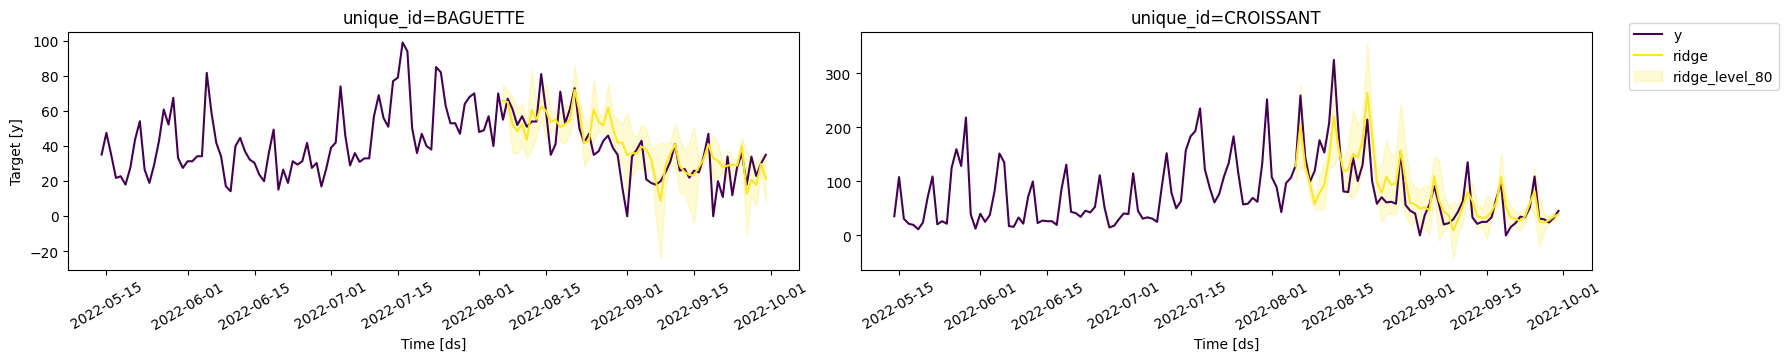

In [40]:
plot_series(
    df=small_df, 
    forecasts_df=ml_prob_cv_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    models=["ridge"],
    max_insample_length=140,
    level=[80],
    palette="viridis"
)

### One model per step in the horizon

In [41]:
ml_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=False,
    static_features=[],
    max_horizon=horizon
)

full_eval_df = baseline_cv_df.merge(ml_cv_df.drop(["cutoff", "y"], axis=1), "left", ["unique_id", "ds"])

full_evaluation = evaluate(
    full_eval_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
full_evaluation = full_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
full_evaluation

,metric,SeasonalNaive,lasso,ridge
0,mae,21.117857,18.980922,19.221881
1,mase,1.328592,1.179125,1.194047


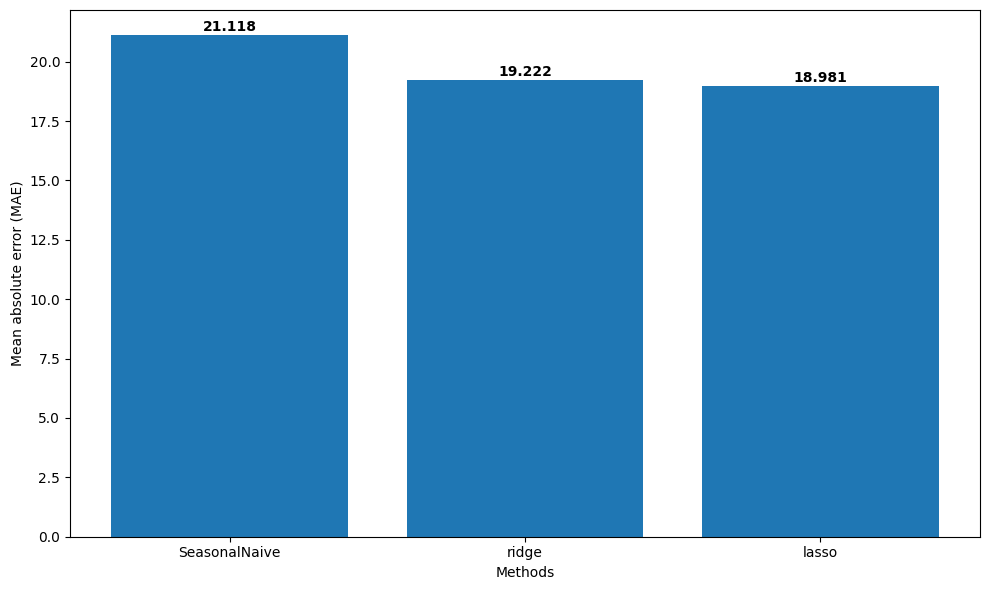

In [42]:
plot_metrics_bar(full_evaluation)

## Hyperparameter optimization
### Tuning the model

In [43]:
import optuna
from mlforecast.auto import AutoMLForecast, AutoLasso

In [44]:
def init_config(trial):
    return {
        "lags":range(1,8),
        "lag_transforms":{
            1: [ExpandingMean()],
            7: [RollingMean(window_size=7)]
        },
    }

def fit_config(trial):
    return {
        "static_features": []
    }

auto_mlf = AutoMLForecast(
    models={"auto_lasso": AutoLasso()},
    freq='D',
    init_config=init_config,
    fit_config=fit_config
)

auto_mlf.fit(
    df=small_df,
    n_windows=8,
    h=horizon,
    step_size=horizon,
    num_samples=10
)

[I 2025-07-08 17:01:33,145] A new study created in memory with name: no-name-c6b3173c-e6e8-455c-b317-a7c09b2c722f
[I 2025-07-08 17:01:33,389] Trial 0 finished with value: 0.172161021579501 and parameters: {'fit_intercept': False, 'alpha': 6.028030997340368}. Best is trial 0 with value: 0.172161021579501.
[I 2025-07-08 17:01:33,629] Trial 1 finished with value: 0.16989203907245465 and parameters: {'fit_intercept': True, 'alpha': 6.459295236553495}. Best is trial 1 with value: 0.16989203907245465.
[I 2025-07-08 17:01:33,863] Trial 2 finished with value: 0.17361994653001162 and parameters: {'fit_intercept': False, 'alpha': 9.636663942249792}. Best is trial 1 with value: 0.16989203907245465.
[I 2025-07-08 17:01:34,096] Trial 3 finished with value: 0.17188842041720753 and parameters: {'fit_intercept': False, 'alpha': 5.289420302609292}. Best is trial 1 with value: 0.16989203907245465.
[I 2025-07-08 17:01:34,335] Trial 4 finished with value: 0.17012666770266918 and parameters: {'fit_intercep

AutoMLForecast(models={'auto_lasso': AutoModel(model=Lasso)})

In [45]:
auto_mlf.results_['auto_lasso'].best_trial.user_attrs['config']

{'model_params': {'fit_intercept': True, 'alpha': 6.459295236553495},
 'mlf_init_params': {'lags': range(1, 8),
  'lag_transforms': {1: [ExpandingMean()], 7: [RollingMean(window_size=7)]},
  'num_threads': 1},
 'mlf_fit_params': {'static_features': []}}

In [46]:
optimized_lasso_config =  auto_mlf.results_['auto_lasso'].best_trial.user_attrs['config']['model_params']

mlf = MLForecast(
    models={
        "default_lasso": Lasso(),
        "optimized_lasso": Lasso(**optimized_lasso_config)
    },
    freq='D',
    lags=range(1,8),
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=7)]
    }
)

ml_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=False,
    static_features=[]
)

full_eval_df = baseline_cv_df.merge(ml_cv_df.drop(["cutoff", "y"], axis=1), "left", ["unique_id", "ds"])

full_evaluation = evaluate(
    full_eval_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
full_evaluation = full_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
full_evaluation

,metric,SeasonalNaive,default_lasso,optimized_lasso
0,mae,21.117857,17.785720,18.341645
1,mase,1.328592,1.107425,1.138568


### Tuning the features

In [47]:
from mlforecast.lag_transforms import ExpandingStd

In [48]:
def tune_init_config(trial):
    expanding_stat_choice = trial.suggest_categorical('expanding_stat', ['ExpandingMean', 'ExpandingStd'])
    date_features_choice = trial.suggest_categorical('date_features', ['month_dayofweek', 'none'])
    target_transform_choice = trial.suggest_categorical('target_transform', ['differences_7', 'none'])
    
    expanding_stat_map = {
        'ExpandingMean': ExpandingMean(),
        'ExpandingStd': ExpandingStd()
    }
    
    date_features_map = {
        'month_dayofweek': ["month", "dayofweek"],
        'none': None
    }
    
    target_transform_map = {
        'differences_7': [Differences([7])],
        'none': None
    }
    
    return {
        "lags": range(1, 8),
        "lag_transforms": {
            1: [expanding_stat_map[expanding_stat_choice]],
            7: [RollingMean(window_size=7)]
        },
        "date_features": date_features_map[date_features_choice],
        "target_transforms": target_transform_map[target_transform_choice]
    }

def fit_config(trial):
    return {
        "static_features": []
    }

auto_mlf = AutoMLForecast(
    models={"auto_lasso": AutoLasso()},
    freq='D',
    init_config=tune_init_config,
    fit_config=fit_config
)

auto_mlf.fit(
    df=small_df,
    n_windows=8,
    h=horizon,
    step_size=horizon,
    num_samples=15
)

[I 2025-07-08 17:01:41,027] A new study created in memory with name: no-name-1f292fa1-b6c2-43a4-8cd8-260a88d523cc
[I 2025-07-08 17:01:41,293] Trial 0 finished with value: 0.16962998923679104 and parameters: {'fit_intercept': False, 'alpha': 6.028030997340368, 'expanding_stat': 'ExpandingMean', 'date_features': 'month_dayofweek', 'target_transform': 'none'}. Best is trial 0 with value: 0.16962998923679104.
[I 2025-07-08 17:01:41,533] Trial 1 finished with value: 0.1754357780560237 and parameters: {'fit_intercept': False, 'alpha': 5.289420302609292, 'expanding_stat': 'ExpandingStd', 'date_features': 'none', 'target_transform': 'none'}. Best is trial 0 with value: 0.16962998923679104.
[I 2025-07-08 17:01:41,787] Trial 2 finished with value: 0.1847380880876311 and parameters: {'fit_intercept': False, 'alpha': 9.786204803985408, 'expanding_stat': 'ExpandingMean', 'date_features': 'month_dayofweek', 'target_transform': 'differences_7'}. Best is trial 0 with value: 0.16962998923679104.
[I 202

AutoMLForecast(models={'auto_lasso': AutoModel(model=Lasso)})

In [49]:
auto_mlf.results_['auto_lasso'].best_trial.user_attrs['config']

{'model_params': {'fit_intercept': True, 'alpha': 4.147204737965246},
 'mlf_init_params': {'lags': range(1, 8),
  'lag_transforms': {1: [ExpandingStd()], 7: [RollingMean(window_size=7)]},
  'date_features': None,
  'target_transforms': None,
  'num_threads': 1},
 'mlf_fit_params': {'static_features': []}}

In [50]:
optimized_lasso_config =  auto_mlf.results_['auto_lasso'].best_trial.user_attrs['config']['model_params']
optimized_feats = auto_mlf.results_['auto_lasso'].best_trial.user_attrs['config']['mlf_init_params']

mlf = MLForecast(
    models={
        "default_lasso": Lasso(),
        "optimized_lasso": Lasso(**optimized_lasso_config)
    },
    freq='D',
    **optimized_feats
)

ml_cv_df = mlf.cross_validation(
    df=small_df,
    h=horizon,
    n_windows=8,
    step_size=horizon,
    refit=False,
    static_features=[]
)

full_eval_df = baseline_cv_df.merge(ml_cv_df.drop(["cutoff", "y"], axis=1), "left", ["unique_id", "ds"])

full_evaluation = evaluate(
    full_eval_df.drop(["cutoff"], axis=1),
    metrics=[mae, partial(mase, seasonality=7)],
    train_df = eval_train_df
)
full_evaluation = full_evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
full_evaluation

,metric,SeasonalNaive,default_lasso,optimized_lasso
0,mae,21.117857,17.809720,18.085167
1,mase,1.328592,1.108518,1.123256
